# Analysis of Tomek's PolII CRAC-seq data with Salmon

**Samples**
- BY4741 + 128 kb neochromosome (+ Rpo31/Rpc160)
- BY4741 + pRS415 (+ Rpo31/Rpc160)
- BY4741 (- Rpo31/Rpc160)

Rpo31/Rpc160 is largest catalytic subunit of RNAPIII. HTP-tagged for CRAC. 

In [1]:
.libPaths("~/R/x86_64-redhat-linux-gnu-library/3.2/")
# config opts and libraries
options(repr.plot.width = 6)
options(repr.plot.height = 5)
options(jupyter.plot_mimetypes = 'image/png')
devtools::source_url("https://raw.githubusercontent.com/scalefreegan/R-tools/master/defaultRlibs.R")
library(forcats)

SHA-1 hash of file is 22fb06d671e2b067831995cd09e786560ab301f3

Attaching package: ‘dplyr’

The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: BiocGenerics

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union

The following objects are masked from ‘package:stats’:

    IQR, mad, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, as.vector, cbind, coln

In [2]:
# load ncRNA annotations
load("/g/steinmetz/project/IESY/trna/data/ncRNA_annotations.rda")

In [3]:
sample2ezname = function(x) {
    o = x
    o[x == "S1"] = "BY4741-neg"
    o[x == "S2"] = "BY4741"
    o[x == "S3"] = "BY4741+neo"
    return(o)
}
chr2ezname = function(x) {
    o = x
    o[x == "chr17"] = "mito"
    o[x == "chr18"] = "neo"
    return(o)
}
RESULTS = "/g/steinmetz/project/IESY/trna/results/polIIIcrac"
S1 = read_tsv(file.path(RESULTS, "04_TT16612_BY4741_mock_comp_17bp/quant.sf"), col_names = T) %>% 
    mutate(sample = "S1")
S2 = read_tsv(file.path(RESULTS, "04_TT16612_BY_Rpc160HTP_wt_comp_17bp/quant.sf"), col_names = T) %>% 
    mutate(sample = "S2")
S3 = read_tsv(file.path(RESULTS, "04_TT16612_BY_Rpc160HTP_Neo_comp_17bp/quant.sf"), col_names = T) %>% 
    mutate(sample = "S3")
results = bind_rows(S1, S2, S3)
results$Name.original = results$Name
results = results %>% separate(Name, into = c("origin","Name"),sep = "\\.", extra = "merge", remove = T)
# because of naming, I need to move to mtrans
mtrnas = which(is.na(results$Name))
if (length(mtrnas) > 0) {
    results$Name[mtrnas] = results$origin[mtrnas]
    results$origin[mtrnas] = NA
} 
# combine with ncRNA annotations
results = merge(results, allncrnas, by = c("Name","origin"))
results = results %>% separate(Name, into = c("tmp1","tmp2"), sep = "-", extra = "merge", remove = F) %>%
    separate(tmp2, into = c("AA","Isotype"), sep = 3, remove = T) %>%
    separate(Isotype, into = c("Isotype","Isotype.Number"), sep = 3, remove = T) %>%
    mutate(mature.trna = ifelse(grepl("tRNA", Name) & !grepl("chr", Name),T,F))
results = results %>% mutate(ezseqid = chr2ezname(seqid), ezsample = sample2ezname(sample))
results$tmp1 = NULL

# customize annotations
results$type[grepl("tRNA",results$Name)] = "mature_tRNA"
results$type[grepl("chr.*tRNA",results$Name)] = "pre_tRNA"
results$type[grepl("snoRNA_gene",results$type)] = "snoRNA"
results$type[grepl("ncRNA_gene",results$type)] = "ncRNA_other"
results$type[grepl("snRNA_gene",results$type)] = "snRNA"
results$type[grepl("rRNA_gene",results$type)] = "rRNA"
results$ezseqid[which(results$type=="mature_tRNA")] = "mature"
results$type = factor(results$type, levels = (c(
"pre_tRNA",
"mature_tRNA",
"rRNA",
"snoRNA",
"snRNA",
"ncRNA_other")))

# save
sf = file.path(RESULTS,"results.rds")
saveRDS(results, file = sf)

Parsed with column specification:
cols(
  Name = col_character(),
  Length = col_integer(),
  EffectiveLength = col_double(),
  TPM = col_double(),
  NumReads = col_double()
)
Parsed with column specification:
cols(
  Name = col_character(),
  Length = col_integer(),
  EffectiveLength = col_double(),
  TPM = col_double(),
  NumReads = col_double()
)
Parsed with column specification:
cols(
  Name = col_character(),
  Length = col_integer(),
  EffectiveLength = col_double(),
  TPM = col_double(),
  NumReads = col_double()
)
Warning message:
: Too few values at 258 locations: 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, ...Warning message:
: Too few values at 309 locations: 1432, 1433, 1434, 1435, 1436, 1437, 1438, 1439, 1440, 1441, 1442, 1443, 1444, 1445, 1446, 1447, 1448, 1449, 1450, 1451, ...

In [4]:
aggresults = acast(results %>% filter(grepl("tRNA",Name)), formula = Name ~ sample, value.var = "TPM", fun.aggregate = median) 
aggresults = log2(aggresults + 1)
colnames(aggresults) = sample2ezname(colnames(aggresults))

# Figure 1: ncRNA TPM reproducibility across samples

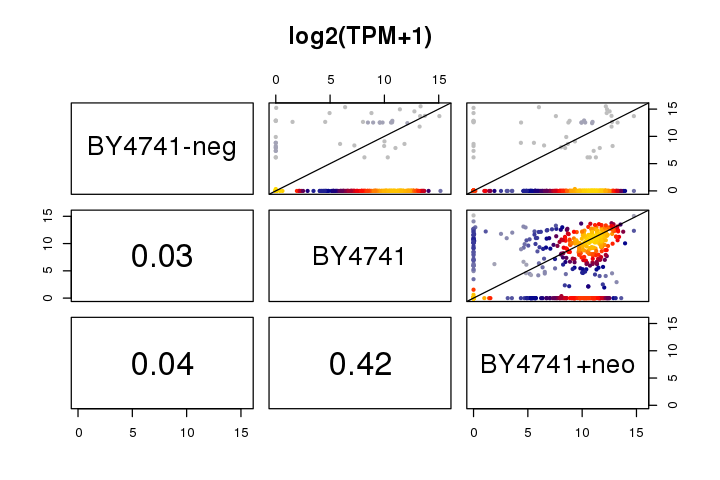

In [5]:
options(repr.plot.width = 6)
options(repr.plot.height = 4)
LSD::heatpairs(aggresults, main = "log2(TPM+1)")

# Figure 2: ncRNA expression across all chromosomes

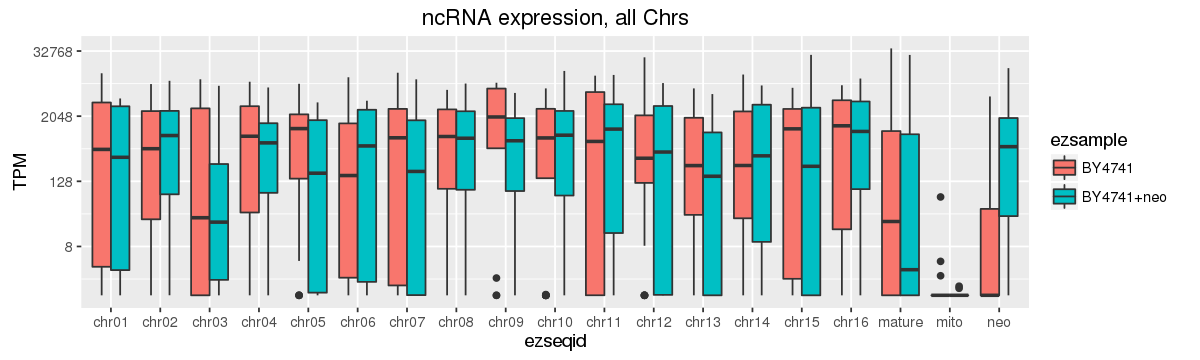

In [6]:
options(repr.plot.width = 10)
options(repr.plot.height = 3)
p2 <- ggplot(results %>% filter(!grepl("-neg",ezsample))) +
    geom_boxplot(aes(ezseqid, TPM+1, fill = ezsample)) + scale_y_continuous(trans="log2") +
    ggtitle("ncRNA expression, all Chrs") + ylab("TPM")
p2

# Figure 3: pre-tRNA expression across all chromosomes

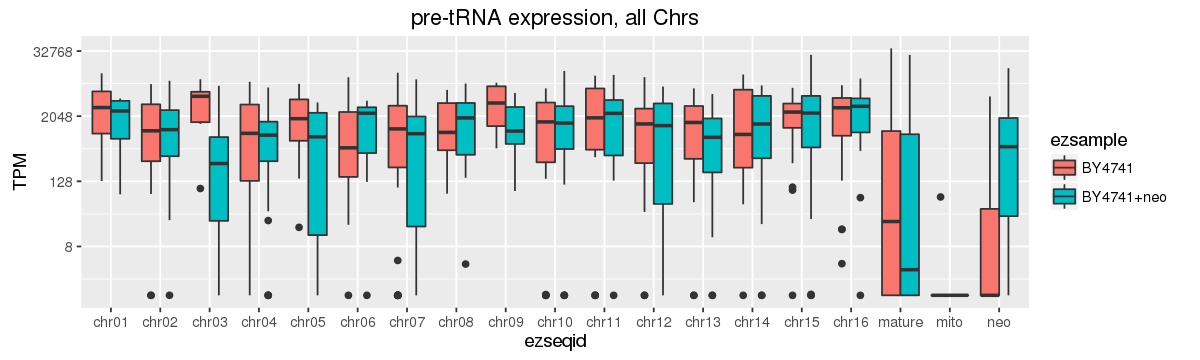

In [7]:
p3 <- ggplot(results %>% filter(grepl("tRNA",Name),!grepl("-neg",ezsample))) +
    geom_boxplot(aes(ezseqid, TPM + 1, fill = ezsample)) + scale_y_continuous(trans="log2") +
    ggtitle("pre-tRNA expression, all Chrs") + ylab("TPM")
p3

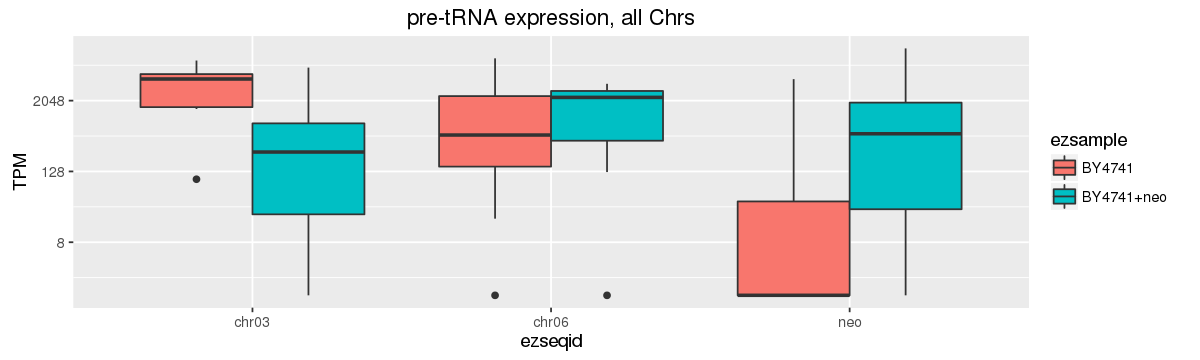

In [8]:
p3.2 <- ggplot(results %>% filter(grepl("tRNA",Name),!grepl("-neg",ezsample),ezseqid %in% c("chr03","chr06","neo"))) +
    geom_boxplot(aes(ezseqid, TPM + 1, fill = ezsample)) + scale_y_continuous(trans="log2") +
    ggtitle("pre-tRNA expression, all Chrs") + ylab("TPM")
p3.2

# Figure 4: ncRNA (non-tRNA) expression across all chromosomes

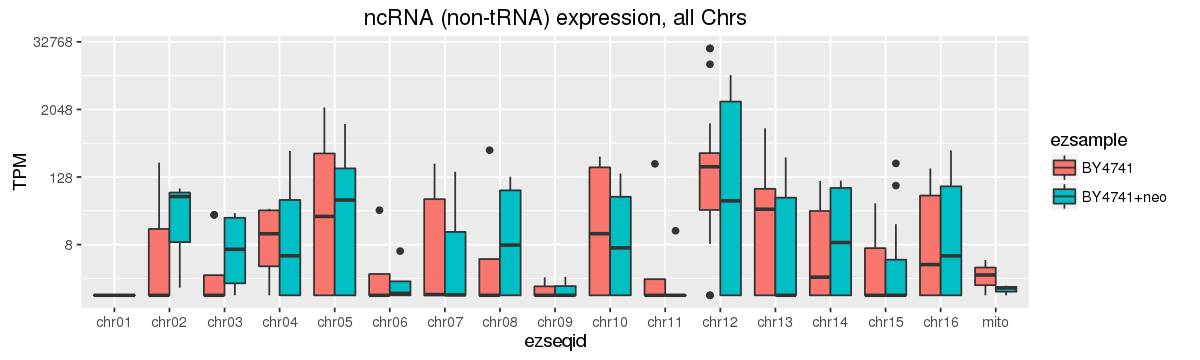

In [9]:
p4 <- ggplot(results %>% filter(!grepl("tRNA",Name),!grepl("-neg",ezsample))) +
    geom_boxplot(aes(ezseqid, TPM + 1, fill = ezsample)) + scale_y_continuous(trans="log2") +
    ggtitle("ncRNA (non-tRNA) expression, all Chrs") + ylab("TPM")
p4

# Figure 5: pre-tRNA by amino acid

**SYN** pre-tRNAs (upper panel) originate from neochromosome

**WT** pre-tRNAs (lower panel) originate from genome

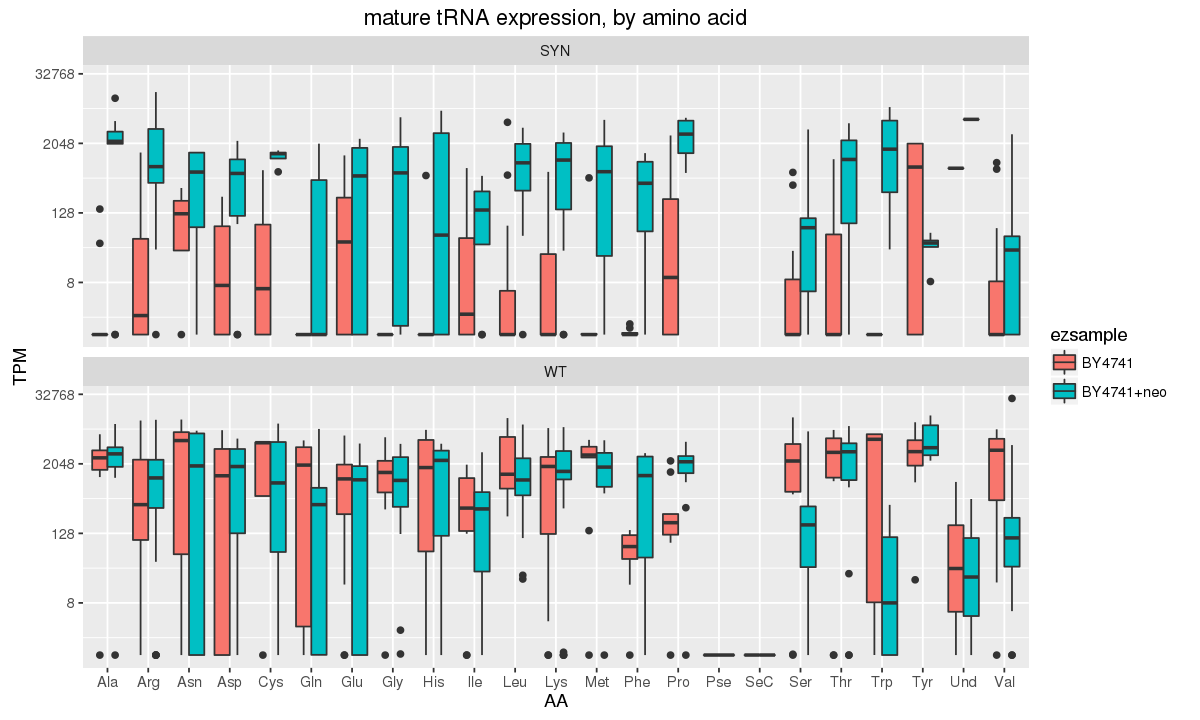

In [17]:
options(repr.plot.width = 10)
options(repr.plot.height = 6)
p5 <- ggplot(results %>% filter(!mature.trna,grepl("tRNA",Name),!grepl("-neg",ezsample))) +
    geom_boxplot(aes(AA, TPM + 1, fill = ezsample)) + scale_y_continuous(trans="log2") +
     ggtitle("mature tRNA expression, by amino acid") + ylab("TPM") +
    facet_wrap(~ origin, nrow = 2)
p5

# Figure 7: Composition of reads (TPMs) by type

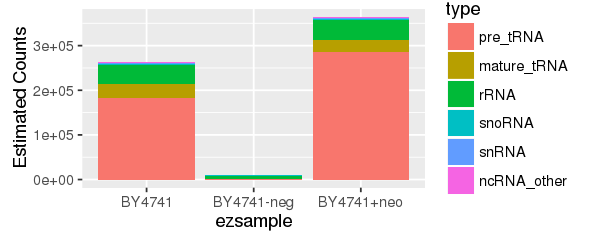

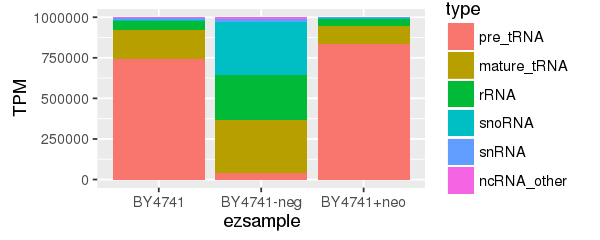

In [18]:
options(repr.plot.width = 5)
options(repr.plot.height = 2)
p7 <- ggplot(results %>% group_by(type, ezsample) %>% summarise(sum=sum(NumReads))) + 
geom_bar(aes(y = sum, x = ezsample, 
    fill = type), stat = "identity") +
    ylab("Estimated Counts")
p7
p7.2 <- ggplot(results %>% group_by(type, ezsample) %>% summarise(sum=sum(TPM))) + 
geom_bar(aes(y = sum, x = ezsample, 
    fill = type), stat = "identity") +
    ylab("TPM")
p7.2